In [1]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

### Keras
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, Dense, Lambda
from keras.layers.core import Dense, Activation, Flatten, RepeatVector
from keras.layers.wrappers import TimeDistributed
from keras.layers.recurrent import GRU
from keras.layers.convolutional import Conv1D, Conv2D, MaxPooling1D
from keras.optimizers import Adam

## Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

RDKit WARNING: [22:33:56] Enabling RDKit 2019.09.1 jupyter extensions
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.2) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


## Cargamos datos y generamos Morgan Fingerprints desde representación SMILES

In [2]:
df = pd.read_csv('Data/IC50_filtered_original.csv')

In [3]:
for i in range(4126):
    smiles = df['structure'][i]
    codificado = Chem.MolFromSmiles(smiles)
    morgan = AllChem.GetMorganFingerprintAsBitVect(codificado, 2, nBits=1024)
    array = np.zeros((0, ), dtype=np.int)
    DataStructs.ConvertToNumpyArray(morgan, array)
    array = array.reshape(1024, 1).T
    if i == 0:
        X = array
    
    else:
        X = np.concatenate((X, array), axis=0) 

In [4]:
y = np.log10(np.array(df['ic50_value']).reshape(4126, 1))

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Creamos y entrenamos red neuronal Feedforward

In [7]:
model = Sequential()

model.add(Dense(2600, input_dim=1024, activation='relu'))
model.add(Dense(1300, activation='relu'))
model.add(Dense(1300, activation='relu'))
model.add(Dense(650, activation='relu'))
model.add(Dense(300, activation='relu'))
model.add(Dense(150, activation='relu'))
model.add(Dense(70, activation='relu'))
model.add(Dense(35, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='linear'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2600)              2665000   
_________________________________________________________________
dense_1 (Dense)              (None, 1300)              3381300   
_________________________________________________________________
dense_2 (Dense)              (None, 1300)              1691300   
_________________________________________________________________
dense_3 (Dense)              (None, 650)               845650    
_________________________________________________________________
dense_4 (Dense)              (None, 300)               195300    
_________________________________________________________________
dense_5 (Dense)              (None, 150)               45150     
_________________________________________________________________
dense_6 (Dense)              (None, 70)                1

In [8]:
# Compile model
model.compile(loss='mse', optimizer='adam', metrics=["mean_absolute_percentage_error"])

checkpoint_name = 'Modelos/morgan_model.h5'
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

model.fit(X_train, y_train, epochs=100, batch_size=20, validation_data = (X_test, y_test), callbacks=callbacks_list)

Epoch 1/100
164/165 [============================>.] - ETA: 0s - loss: 1.6801 - mean_absolute_percentage_error: 859743.4375
Epoch 00001: val_loss improved from inf to 0.61708, saving model to morgan_model.h5
165/165 [==============================] - 7s 43ms/step - loss: 1.6726 - mean_absolute_percentage_error: 854532.9375 - val_loss: 0.6171 - val_mean_absolute_percentage_error: 43.8055
Epoch 2/100
165/165 [==============================] - ETA: 0s - loss: 0.4130 - mean_absolute_percentage_error: 642502.4375
Epoch 00002: val_loss improved from 0.61708 to 0.52751, saving model to morgan_model.h5
165/165 [==============================] - 7s 41ms/step - loss: 0.4130 - mean_absolute_percentage_error: 642502.4375 - val_loss: 0.5275 - val_mean_absolute_percentage_error: 37.5396
Epoch 3/100
165/165 [==============================] - ETA: 0s - loss: 0.2569 - mean_absolute_percentage_error: 473147.0625
Epoch 00003: val_loss improved from 0.52751 to 0.50730, saving model to morgan_model.h5
165/

In [9]:
pred_train= model.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train))) 
pred_test= model.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred_test))) 

0.11866011052920426
0.6261124912265231


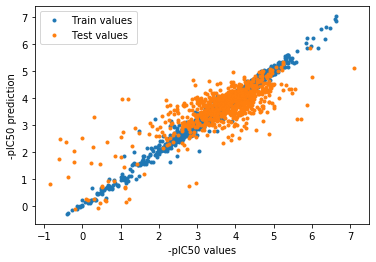

In [21]:
plt.figure(3)
plt.clf()

plt.xlabel('-pIC50 values')
plt.ylabel('-pIC50 prediction')
plt.plot(y_train, pred_train ,'.', label = 'Train values')
plt.plot(y_test, pred_test, '.', label = 'Test values')
plt.legend()
plt.show()


In [12]:
r2_score(y_test, pred_test)

0.6026707412408016

# Cargamos mejor modelo obtenido

In [8]:
modelo = Sequential()

modelo.add(Dense(2600, input_dim=1024, activation='relu'))
modelo.add(Dense(1300, activation='relu'))
modelo.add(Dense(1300, activation='relu'))
modelo.add(Dense(650, activation='relu'))
modelo.add(Dense(300, activation='relu'))
modelo.add(Dense(150, activation='relu'))
modelo.add(Dense(70, activation='relu'))
modelo.add(Dense(35, activation='relu'))
modelo.add(Dense(15, activation='relu'))
modelo.add(Dense(5, activation='relu'))
modelo.add(Dense(1, activation='linear'))

modelo.load_weights("Modelos/morgan_model.h5")

In [9]:
pred_train= modelo.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train))) 
pred_test= modelo.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred_test))) 

0.15053620178296365
0.5883228831073802


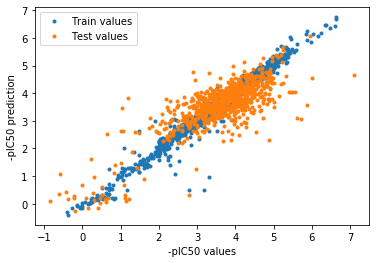

In [12]:
plt.figure(3)
plt.clf()
plt.xlabel('-pIC50 values')
plt.ylabel('-pIC50 prediction')
plt.plot(y_train, pred_train ,'.', label = 'Train values')
plt.plot(y_test, pred_test, '.', label = 'Test values')
plt.legend()
plt.savefig("Images/Morgan.png")
plt.show()

In [13]:
r2_score(y_test, pred_test)

0.6491856965262693